# 02 drought monitoring and drought index comparison
## GOAL
1. Load SSM data from ASCAT
2. Process climatology from timeseries
3. Compute various drought based indicators
4. Plot the datasets 


## DATASET
The dataset we will use is available on the Copernicus Global Land Service:
"Soil Water Index 2007-present (raster 12.5 km), global, daily – version 3"

Provides daily updates on the moisture conditions in different soil layers.   
The data are available over the globe at the spatial resolution of 0.1° and with the temporal extent from January 2007 to present.

For this specific example we will use a preprocessed dataset over Mozambique. The data is temporally resampled as dekadal.  
We will also use the data at a t value at 010.

## PROCESSING
We will develop drought indicators such as:
- Soil Moisture Anomalies
- Anomaly quantiles
- Z-Scores

In [6]:
# Packages
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
from pathlib import Path
import numpy as np
import cartopy.feature as cfeature

# Load the dataset
ascat_swi = xr.open_dataset(Path(r"C:/Users/samue/work/data/c_gls_SWI_2007_2024_GLOBE_ASCAT_V3.2.1_mozambique.nc"))
ascat_swi



<xarray.Dataset>
Dimensions:  (lat: 170, lon: 110, time: 629)
Coordinates:
  * lat      (lat) float64 -10.05 -10.15 -10.25 -10.35 ... -26.75 -26.85 -26.95
  * lon      (lon) float64 30.05 30.15 30.25 30.35 ... 40.65 40.75 40.85 40.95
  * time     (time) datetime64[ns] 2007-01-01 2007-01-11 ... 2023-12-27
Data variables:
    SWI_010  (time, lat, lon) float32 ...

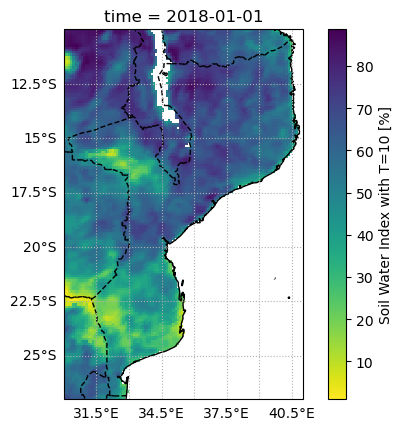

In [7]:
# Visualisation
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ascat_swi.sel(time=datetime(2018, 1, 1)).SWI_010.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
    add_colorbar=True
    )
# Add coastlines and country borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='--')
# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle=':')
gl.top_labels = False
gl.right_labels = False

In [8]:
# Process the climatology of a given timeseries
latitude, longitude = -23.65, 33.10 # Feel free to play around with the latitude and longitude values

ascat_swi_ts = ascat_swi.sel(lat=latitude, lon=longitude, method='nearest')
ascat_swi_ts

<xarray.Dataset>
Dimensions:  (time: 629)
Coordinates:
    lat      float64 -23.65
    lon      float64 33.15
  * time     (time) datetime64[ns] 2007-01-01 2007-01-11 ... 2023-12-27
Data variables:
    SWI_010  (time) float32 ...

Using the climatology, we can process the soil moisture anomaly as following:  
  
  
<span style="font-size:1.5em;">SMA = SM<sub>k,i</sub> - <span style="text-decoration:overline;">SM</span></span><sub>i</sub>


The anomalies provide information on the deviation from  the expected soil moisture at a given dekad.  
If the SWI value is lower than the climatology, a drought is expected as the water content is lower than average.  
By mapping the percentile of the anomaly timeserie we can categorize the anomalies as indicator of drought severity.  


In [9]:
swi_pd = pd.DataFrame({"SWI_T010":ascat_swi_ts.SWI_010}, index=ascat_swi_ts.time)

# Extract the day of the year (doy) and create a dekadal index
swi_pd['doy'] = swi_pd.index.dayofyear
swi_pd['dekad'] = ((swi_pd['doy'] - 1) // 10) + 1
dekadal_climatology = swi_pd.groupby('dekad')['SWI_T010'].mean().to_frame().rename(columns={"SWI_T010":"climatology"})

# Get the number of years
how_many_years = len(swi_pd.index.year.unique())

# Merge the original dataset with the dekadal climatology
merged_df = pd.merge(swi_pd, dekadal_climatology, on='dekad', how='left')
merged_df.index = swi_pd.index

# Appl a varying degree of smoothing for the climatology
smoothing_window = 3
merged_df["climatology"] = merged_df["climatology"].rolling(smoothing_window, min_periods=1).mean()
merged_df


,SWI_T010,doy,dekad,climatology
2007-01-01,67.949997,1,1,55.573528
2007-01-11,61.250000,11,2,57.182352
2007-01-21,60.700001,21,3,58.020587
2007-01-31,49.150002,31,4,58.277449
2007-02-10,43.599998,41,5,56.902504
...,...,...,...,...
2023-11-17,53.400002,321,33,41.403920
2023-11-27,49.000000,331,34,43.347059
2023-12-07,51.450001,341,35,44.795099
2023-12-17,67.349998,351,36,47.159804


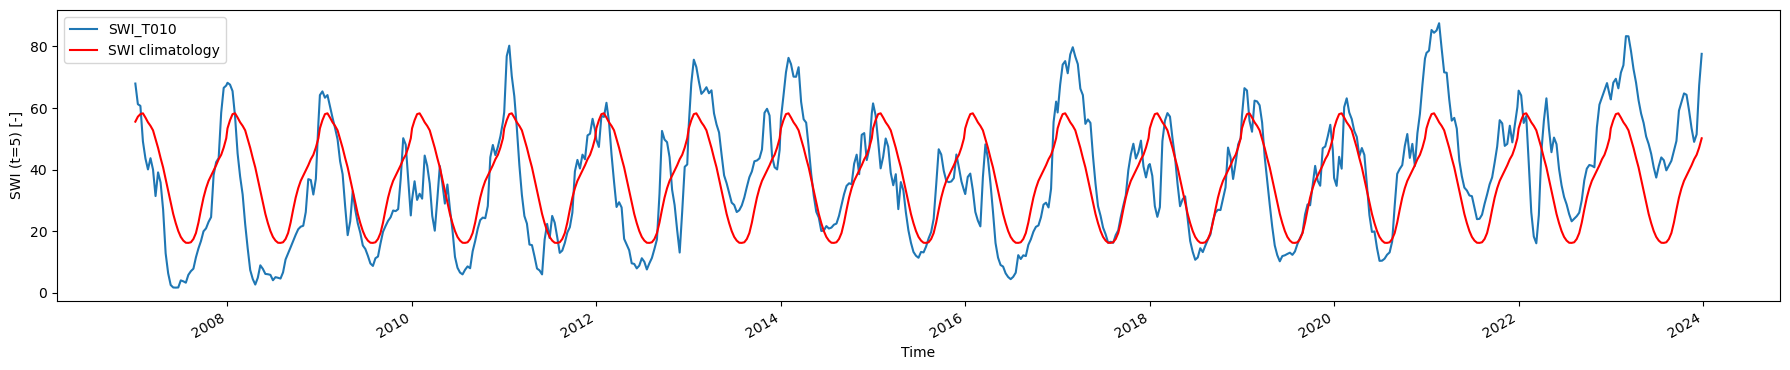

In [11]:
# Process the simplest approach: Soil Moisture Anomalies
fig, ax = plt.subplots()
merged_df["Soil moisture anomalies"] = merged_df["SWI_T010"]  - merged_df["climatology"] 

#
merged_df.SWI_T010.plot(figsize=(18, 3.8), label="SWI_T010", ax=ax)
merged_df.climatology.plot(figsize=(18,3.8), label="SWI climatology", ax=ax, color="r")

# plot the soil moisture anomalies
soil_moisture_anomalies = merged_df["Soil moisture anomalies"].to_frame()

# We're interested in negative anomalies only
soil_moisture_anomalies["SMA_below_0"] = soil_moisture_anomalies["Soil moisture anomalies"]
soil_moisture_anomalies.loc[soil_moisture_anomalies["SMA_below_0"]<0, "SMA_below_0"] = np.nan

ax.legend(loc="upper left")

# labelling
ax.set_ylabel("SWI (t=5) [-]")
ax.set_xlabel("Time")

plt.tight_layout()
plt.show()

This approach being data driven is beneficial.  
No external datasets are required and the thresholds can be tweaked depending on the needs.
Additionally, we can also process and map the quantiles of the anomalies. 

In [ ]:
from matplotlib.gridspec import GridSpec


# plot the soil moisture anomalies
merged_df['Percentile'] = merged_df['Soil moisture anomalies'].rank(pct=True) * 100

# Please play around with the values here
drought_levels = {0: 'SM deficit', 1: 'Mild Drought', 2: 'Moderate Drought', 
                  3: 'Significant Drought', 4: 'Severe Drought', 5: 'Extreme Drought', }

bins = merged_df['Soil moisture anomalies'].quantile([0, 0.01, 0.02, 0.05, 0.1, 0.2, .5]).values


fig = plt.figure(figsize=(15, 15))
gs = GridSpec(2, 1, height_ratios=(2,4), hspace=.63)
ax = fig.add_subplot(gs[0, 0],)
ax.axhline(0, color='k', linestyle='--')
ax.axhspan(bins[4], bins[5], color='#fee5d9', alpha=0.5, label='mild')
ax.axhspan(bins[3], bins[4], color='#fcbba1', alpha=0.5, label='moderate')
ax.axhspan(bins[2], bins[3], color='#fc9272', alpha=0.5, label='significant')
ax.axhspan(bins[1], bins[2], color='#fb6a4a', alpha=0.5, label='severe')
ax.axhspan(bins[0], bins[1], color='#de2d26', alpha=0.5, label='extreme')

p = merged_df['Soil moisture anomalies'].plot(
    marker='o', 
    color='black', 
    ax=ax, 
    ylabel="Percentile", 
    markersize=3,
    alpha=0.5
    )
plt.legend(loc="lower right", fontsize=6)
plt.show()
plt.close()



plt.hist(merged_df["Soil moisture anomalies"], bins=50, edgecolor='black')
plt.title("Distribution of the anomalies")


## Z-score processing
An alternative way to categorize anomalies into drought severity is to process the Z-score values.  
Here, we normalize the anomalies by the standard deviation 

The formula for calculating a Z-score is given by:  

<span style="font-size:1.5em;">Z = (X - μ) / σ</span>

Where:

- <span style="font-size:1.5em;">Z</span> is the Z-score value of the anomalies
- <span style="font-size:1.5em;">X</span> is the raw SMA at a given time (per period length)
- <span style="font-size:1.5em;">μ</span> is the mean of SMA dataset (per period length)
- <span style="font-size:1.5em;">σ</span> is the standard deviation of the entire SMA dataset (per period length)

The dynamics won't change but the classification could.

In [ ]:
# Z-score processing, starting from our soil moisture anomalies processed earlier
X = merged_df['Soil moisture anomalies']

grouped_stats = merged_df.groupby('dekad')['Soil moisture anomalies'].agg(['mean', 'std'])

# Tile the mean and std data for the number of years
merged_df["tiled_mean"] = np.tile(grouped_stats['mean'].values, how_many_years)
merged_df["tiled_std"] = np.tile(grouped_stats['std'].values, how_many_years)
merged_df["Z-score"] = (X - merged_df["tiled_mean"]) / merged_df["tiled_std"]

# We can compare the two approaches now
fig, ax = plt.subplots(2)
drought_levels = {0: 'SM deficit', 1: 'Mild Drought', 2: 'Moderate Drought', 
                  3: 'Significant Drought', 4: 'Severe Drought', 5: 'Extreme Drought', }

bins = merged_df['Soil moisture anomalies'].quantile([0, 0.01, 0.02, 0.05, 0.1, 0.2, .5]).values

merged_df["Soil moisture anomalies"].plot(figsize=(18, 3.8), label="SMA", ax=ax[0])
ax[0].axhline(0, color='k', linestyle='--')
ax[0].axhspan(bins[4], bins[5], color='#fee5d9', alpha=0.5, label='mild')
ax[0].axhspan(bins[3], bins[4], color='#fcbba1', alpha=0.5, label='moderate')
ax[0].axhspan(bins[2], bins[3], color='#fc9272', alpha=0.5, label='significant')
ax[0].axhspan(bins[1], bins[2], color='#fb6a4a', alpha=0.5, label='severe')
ax[0].axhspan(bins[0], bins[1], color='#de2d26', alpha=0.5, label='extreme')


# rewrite the bins for Z-score according to litterature
drought_levels = {1: "Mild", 2: "Moderate", 3:"Severe" }
bins = [0, -1, -2, -5]

merged_df["Z-score"].plot(figsize=(18, 3.8), label="Z-score", ax=ax[1])
merged_df["Soil moisture anomalies"].plot(figsize=(18, 3.8), label="SMA", ax=ax[0])
ax[1].axhline(0, color='k', linestyle='--')
ax[1].axhspan(bins[3], bins[2], color='#de2d26', alpha=0.5, label='severe')
ax[1].axhspan(bins[2], bins[1], color='#fcbba1', alpha=0.5, label='mild')
ax[1].axhspan(bins[1], bins[0], color='#fee5d9', alpha=0.5, label='moderate')

ax[0].legend(loc="upper left", fontsize=8)
ax[1].legend(loc="upper left", fontsize=8)
plt.tight_layout()


As you can see, the way the data is 
# This can be processed for the entire country

In [17]:
# We already previously processed both the dekad and doy indexes
ascat_swi.coords['doy'] = ("time", swi_pd.index.dayofyear)
ascat_swi.coords['dekad'] = ("time", ((swi_pd['doy'] - 1) // 10) + 1)

mapped_climatology = ascat_swi.SWI_010.groupby('dekad').mean(dim='time')

# check the number of years
expanded_climatology = np.tile(mapped_climatology, (how_many_years, 1, 1))
ascat_swi["expanded_climatology"] = (["time", "lat", "lon"], expanded_climatology)
ascat_swi["anomalies"] = ascat_swi["SWI_010"] - ascat_swi["expanded_climatology"]

# extract the arrays for processing statistics
ascat_ssm_anomaly_arr = ascat_swi["anomalies"].values
dekad_arr = ascat_swi["anomalies"].dekad.values

n_dekads = len(np.unique(dekad_arr))
# Initialize arrays to hold the results
mean_array = np.zeros((n_dekads, 170, 110))
std_array = np.zeros((n_dekads, 170, 110))

mean_array[:] = np.nan
std_array[:] = np.nan

# Loop through each dekad and calculate mean and std
for dekad_num in range(1, n_dekads + 1):
    # Get the indices of the current dekad
    indices = np.where(dekad_arr == dekad_num)
    
    # Extract the data for the current dekad
    dekad_data = dekad_arr[indices]

    # Calculate mean and std

    mean_array[dekad_num - 1] = ascat_ssm_anomaly_arr.mean(axis=0)
    std_array[dekad_num - 1] = ascat_ssm_anomaly_arr.std(axis=0)

# tile it back to the initial xarray for the final step
replicated_mean_array = np.tile(mean_array, (how_many_years, 1, 1))
replicated_std_array = np.tile(std_array, (how_many_years, 1, 1))


ascat_swi["mean_anomalies"] = (["time", "lat", "lon"], replicated_mean_array)
ascat_swi["std_anomalies"] = (["time", "lat", "lon"], replicated_std_array)

# finally process the z-score
ascat_swi["Z-score"] = (ascat_swi["anomalies"] - ascat_swi["mean_anomalies"]) / ascat_swi["std_anomalies"]
ascat_swi_z_score_only = ascat_swi["Z-score"]


In [ ]:
ascat_swi_z_score_only

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import cmcrameri.cm as cmc

# Define the figure and axis, here you can change the filtered data
fig, ax = plt.subplots()
data = ascat_swi_z_score_only.sel(
    time=slice('2021-06-01', '2022-06-01'))


# Initialize the plot with the first time step
def init():
    global img
    data_at_time0 = data.isel(time=0).values
    img = ax.imshow(data_at_time0, vmin=-3, vmax=3, cmap=cmc.vik_r, animated=True)
    ax.set_title('Time: {}'.format(data.time.values[0]))
    
    return img,

# Function to update the plot
def update(frame):
    data_at_time = data.isel(time=frame).values
    img.set_array(data_at_time)
    ax.set_title('Time: {}'.format(data.time.values[frame]))
    return img,

# Creating the animation
num_frames = len(data.time)
ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True)
fig.colorbar(img, ax=ax)
# Display the animation in the notebook
plt.close(fig)
HTML(ani.to_jshtml())
